<a href="https://colab.research.google.com/github/Kaguya2906/Anomaly_Detection_Weekly_Project/blob/main/11.GLM%2CAutoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The Boosting method fits many small models sequentially to reduce the error. It first builds a small model and calculates the residual error between the actual and the prediction. The error will be large, but no problem. In the second round, it aims at the residual error from the first round and builds a small model to reduce it. In the third round, it takes the previous residual error as the target and builds another small model to reduce it. This goes on and on until the residual error is reduced to zero. Once you aggregate all these small models, the predictability of the collective models delivers superior results. These small models are called weak learners. The superpower is not in each small model but in in the special process — it attacks the error sequentially until the error is close to zero. The best-known example is the gradient boosting technique.

In the unsupervised learning methods, I apply a Step 1–2–3 modeling procedure for (1) Model development, (2) Threshold determination, and (3) Profiles of the normal and abnormal groups. However, we can skip (2) because the target is known in XGBOD.

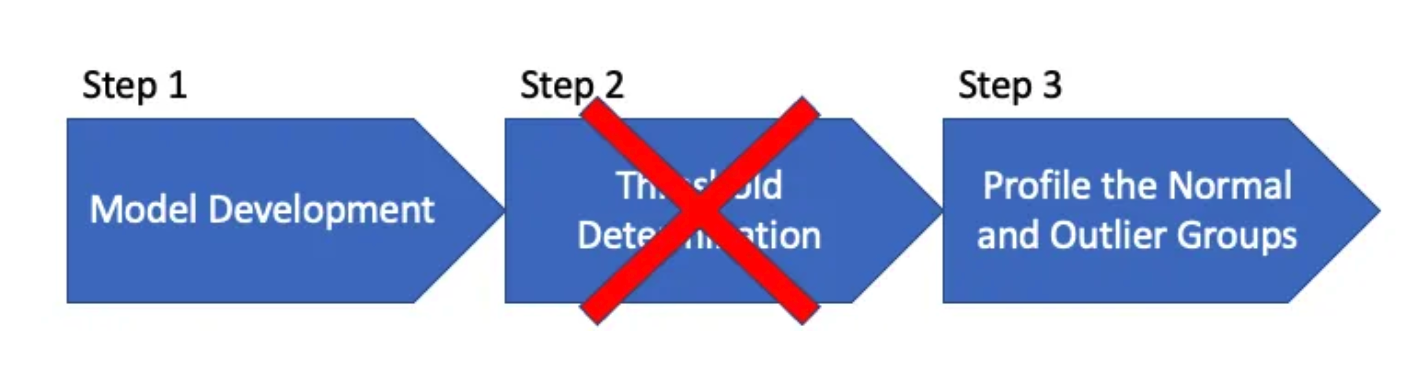




# Libraries, Dataset

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Preprocessing

Because previously in the assignment 8 and 9, I've done with the data preprocessing and convert the cleaned one into a new df, here I just paste all the steps together in order to make the code compact. I'll directly upload the processed df for further modeling, named "MortgageDefault_Cleaned.csv".

In [ ]:
# drop non-useful columns
df= df.drop(columns=['Unnamed: 0.1',	'Unnamed: 0'])
# Function to filter column names that are not int64 or float64
def filter_non_numeric_columns(df):
    non_numeric_columns = [col for col in df.columns if not pd.api.types.is_numeric_dtype(df[col])]
    return non_numeric_columns
filtered_columns = filter_non_numeric_columns(df)
#['AP005', 'AP006', 'MB007']
# AP005: turn to dateframe that only reflects year and month
from datetime import datetime
df['AP005'] = pd.to_datetime(df['AP005'])
# Extract the year and month into new columns
df['Year'] = df['AP005'].dt.year
df['Month'] = df['AP005'].dt.month
# Drop the original 'AP005' column if needed
df.drop(columns=['AP005'], inplace=True)
# AP006: Dummy Encoding
df['AP006'].unique()
df = pd.get_dummies(df, columns=['AP006'])
# MB007: Featurehasher
df['MB007'].unique()
from sklearn.feature_extraction import FeatureHasher
n_features = 10
hasher = FeatureHasher(n_features=n_features, input_type='string')
# Convert the 'MB007' column to a list of dictionaries
MB007 = df['MB007'].apply(lambda x: {'MB007': x}).tolist()
# Perform feature hashing on MB007
hashed_features = hasher.transform(MB007)
# Convert the hashed features into a DataFrame
hashed_df = pd.DataFrame(hashed_features.toarray())
# Concatenate the hashed features DataFrame with the original DataFrame (optional)
df = pd.concat([df, hashed_df], axis=1)
# Use FastKNN to Impute Null Values
columns_null = df.columns[df.isnull().any()]
columns_null
!pip install impyute
from impyute.imputation.cs import fast_knn
from sklearn.preprocessing import LabelEncoder
# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include='number').columns.tolist()
categorical_cols = df.select_dtypes(exclude='number').columns.tolist()
# KNN imputation on numeric columns
#numeric_data = df[numeric_cols].values
#imputed_numeric_data = fast_knn(numeric_data, k=30)
# Convert the imputed numeric array back to a DataFrame
#imputed_df_numeric = pd.DataFrame(imputed_numeric_data, columns=numeric_cols)
# Convert categorical columns to numerical using LabelEncoder
label_encoders = {}
for col in categorical_cols:
    label_encoder = LabelEncoder()
    df[col] = label_encoder.fit_transform(df[col].astype(str))
    label_encoders[col] = label_encoder
# Merge imputed numeric DataFrame with categorical columns
df = pd.concat([df[categorical_cols], imputed_df_numeric], axis=1)
# Convert back categorical columns to their original form
for col, label_encoder in label_encoders.items():
    df[col] = label_encoder.inverse_transform(df[col])
# Check null values
columns_with_null = df.columns[df.isnull().any()]
columns_with_null
df.head(2)

,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,...,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
0,1,1,31,2,1,12,2017/7/6 10:21,ios,3,3,...,13.0,13.0,0.0,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7
1,2,0,27,1,1,12,2017/4/6 12:51,h5,5,4,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB


In [ ]:
file_path = '/content/drive/MyDrive/AA的课/APAN 5420/MortgageDefault_Cleaned.csv'
df = pd.read_csv(file_path)
df = df.drop(columns=['Unnamed: 0','id'])

Dropping bad and constant columns/features: [0, 1, 2, 3, CR012, Year, 4, 5, 6, 7, 8, TD028, 9, TD027, TD026, TD025]

In [ ]:
columns_to_drop = ['TD062', 'AP006_ios']
#df.drop(columns=columns_to_drop,inplace=True

## New df

Everything looks good now.

In [ ]:
df.sample(10)

,loan_default,AP001,AP002,AP003,AP004,AP007,AP008,AP009,TD001,TD002,...,0,1,2,3,4,5,6,7,8,9
15509,0.0,28.0,2.0,1.0,3.0,5.0,3.0,0.0,5.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
67966,1.0,42.0,1.0,1.0,12.0,4.0,4.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
62757,0.0,45.0,1.0,1.0,9.0,1.0,1.0,1.0,2.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
46277,0.0,41.0,2.0,1.0,12.0,5.0,5.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
52639,0.0,30.0,2.0,3.0,12.0,3.0,3.0,1.0,2.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
19569,0.0,31.0,1.0,4.0,12.0,2.0,2.0,1.0,3.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
60242,1.0,31.0,1.0,3.0,12.0,2.0,2.0,1.0,4.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
29523,1.0,25.0,1.0,3.0,12.0,3.0,3.0,1.0,2.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
17147,1.0,25.0,2.0,1.0,12.0,3.0,3.0,1.0,2.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
66684,1.0,31.0,1.0,1.0,12.0,5.0,4.0,0.0,2.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## h2o initiation, h2oFrame train-test split

In [ ]:
pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.42.0.2-py2.py3-none-any.whl size=249153908 sha256=432b0519baa0c3925b538744ce453e4705a45b4fcda2f5bcc55401caba40415e
  Stored in directory: /root/.cache/pip/wheels/31/f7/e0/e32942d9f76cb1cb14c949b7772eb78979d2e0132aae6c6780
Successfully built h2o


In [ ]:
import h2o
h2o.init()

from sklearn.model_selection import train_test_split
train,test = train_test_split(df,test_size=0.4,random_state=1234)
df_hex = h2o.H2OFrame(df)
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.20" 2023-07-18; OpenJDK Runtime Environment (build 11.0.20+8-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.20+8-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp8xf1t7i5
  JVM stdout: /tmp/tmp8xf1t7i5/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp8xf1t7i5/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.2
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_unknownUser_ie9tbl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


## specify predictors and target

In [ ]:
X = df.drop(columns=['loan_default']) # predictors
y = df['loan_default'] # target

predictors = X.columns.tolist()
target = 'loan_default'

# H2O Model Preparations

H2O is a fully open-source, distributed in-memory machine-learning platform with linear scalability. H2O supports the most widely used statistical & machine learning algorithms including gradient-boosted machines, generalized linear models, deep learning, and more. H2O also has an industry-leading AutoML functionality that automatically runs through all the algorithms and their hyperparameters to produce a leaderboard of the best models. The H2O platform is used by over 18,000 organizations globally and is extremely popular in both the R & Python communities.

# (A)H2O Generalized Linear Model



In [ ]:
import h2o
h2o.init()

from sklearn.model_selection import train_test_split
train,test = train_test_split(df,test_size=0.4,random_state=1234)
df_hex = h2o.H2OFrame(df)
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 min 43 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.2
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_unknownUser_ie9tbl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.118 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


## GLM_WO Regularization Base Model

In [ ]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

GLM_WO = H2OGeneralizedLinearEstimator(
    family="gaussian",
    lambda_=1e-5,
    alpha=0.5,
)

In [ ]:
GLM_WO.train(x = predictors,
              y = target,
              training_frame = train_hex)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1690422757368_3639


GLM Model: summary
    family    link      regularization                               number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  -------------------------------------------  ----------------------------  -----------------------------  ----------------------  ------------------------------------------------------
    gaussian  identity  Elastic Net (alpha = 0.5, lambda = 1.0E-5 )  80                            80                             1                       Key_Frame__upload_baebc34e74f66801f274e3e81d9b4b41.hex

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.144846217918396
RMSE: 0.3805866759601497
MAE: 0.297180322265625
RMSLE: 0.2683973127331795
Mean Residual Deviance: 0.144846217918396
R^2: 0.07220658083475284
Null degrees of freedom: 79999
Residual degrees of freedom: 79919
Null deviance: 12489.523200001215
Residual deviance: 11587.69743347168
AIC: 72627.55207756735

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective           training_rmse       training_deviance    training_mae       training_r2
--  -------------------  ----------  ------------  -------------------------  ------------------  ------------------  -------------------  -----------------  -------------------
    2023-07-27 03:55:30  0.000 sec   0             12489.523200001215         0.1561190400000152
    2023-07-27 03:55:30  0.655 sec   1                                                            0.3805866759601497  0.144846217918396    0.297180322265625  0.07220658083475284

Variable Importances: 
variable    relative_importance     scaled_importance      percentage
----------  ----------------------  ---------------------  ----------------------
CD106       0.0625993013381958      1.0                    0.05964765546193801
CD108       0.057560648769140244    0.9195094440138558     0.05484658251053665
CD107       0.05740749090909958     0.9170628055248219     0.05470064626090284
AP003       0.04921761527657509     0.7862326611390518     0.04689693488454482
AP004       0.045448169112205505    0.7260171941324        0.043305223455052354
CD100       0.037761084735393524    0.6032189485851832     0.03598059601332151
CD172       0.032997019588947296    0.5271148221076666     0.031441163297958846
CD114       0.03173350542783737     0.5069306645515986     0.030237225622265024
TD013       0.030503282323479652    0.4872783189493469     0.029065009282762986
CD173       0.030161850154399872    0.48182407007146927    0.028739676124891676
---         ---                     ---                    ---
PA028       0.0007482005748897791   0.01195221925637139    0.0007129218562095816
TD002       0.0006769894971512258   0.010814649407886468   0.000645068481823264
TD029       0.0005897816736251116   0.009421537637277884   0.0005619726309100328
CD088       0.0005663610645569861   0.009047402326380492   0.00053965633678948
TD061       0.00038931681774556637  0.006219187905025699   0.00037095997741202493
PA031       0.00038078101351857185  0.006082831683078757   0.0003628266484652422
CR019       0.00026962810079567134  0.0043072062312483695  0.0002569147532850152
TD044       0.00022684191935695708  0.0036237132764698515  0.00021614600100772425
id          0.00021821701375301927  0.0034859336939575595  0.00020792777194034135
TD051       6.245125405257568e-05   0.0009976350009911405  5.950658881588974e-05
[80 rows x 4 columns]


[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [ ]:
y_pred = GLM_WO.predict(test_hex).as_data_frame()
y_pred.head()

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,predict
0,0.265625
1,0.003906
2,0.304688
3,0.261719
4,0.003906


In [ ]:
from sklearn.metrics import roc_auc_score

y_pred_series = y_pred['predict'].as_data_frame()['predict']

GLM_WO_roc_auc_value = roc_auc_score(y_actual, y_pred_series)
print("GLM_WO ROC AUC:", GLM_WO_roc_auc_value)

GLM_WO ROC AUC: 0.6982483073098344


## Hyper Parameter tuning

For GLM, hyperparameters that worth tuning are: family, lambda(aka regularization), p_values(whether incorporating p_values as statistical significance into the model coefficients)

Here I choose to tune the lambda denoted for incorporating regularization or not.

## H2O Generalized Linear Model with Regularization



In [ ]:
import h2o
h2o.init()

from sklearn.model_selection import train_test_split
train,test = train_test_split(df,test_size=0.4,random_state=1234)
df_hex = h2o.H2OFrame(df)
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,17 mins 41 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.2
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_unknownUser_ie9tbl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.964 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
X = df.drop(columns=['loan_default']) # predictors
y = df['loan_default'] # target

predictors = X.columns.tolist()
target = 'loan_default'

In [ ]:
GLM_WITH = H2OGeneralizedLinearEstimator(family= "binomial",
                                          lambda_search = True)

In [ ]:
GLM_WITH.train(x = predictors,
              y = target,
              training_frame = train_hex)

glm Model Build progress: |

/usr/local/lib/python3.10/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1690422757368_3640


GLM Model: summary
    family    link    regularization                                 lambda_search                                                                number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  ---------------------------------------------  ---------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ------------------------------------------------------
    binomial  logit   Elastic Net (alpha = 0.5, lambda = 3.945E-4 )  nlambda = 100, lambda.max = 0.115, lambda.min = 3.945E-4, lambda.1se = -1.0  81                            65                             80                      Key_Frame__upload_9363c4b151510df434fcc1fc49034b9d.hex

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1443451679885191
RMSE: 0.3799278457661653
LogLoss: 0.4529976755941519
AUC: 0.6970491912751686
AUCPR: 0.3444421105048932
Gini: 0.39409838255033725
Null degrees of freedom: 47999
Residual degrees of freedom: 47934
Null deviance: 47214.999180510524
Residual deviance: 43487.77685703858
AIC: 43619.77685703858

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20271305028526432
       0      1      Error    Rate
-----  -----  -----  -------  -----------------
0      25476  13217  0.3416   (13217.0/38693.0)
1      3437   5870   0.3693   (3437.0/9307.0)
Total  28913  19087  0.347    (16654.0/48000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.202713     0.413468  228
max f2                       0.113585     0.5784    315
max f0point5                 0.30205      0.371349  146
max accuracy                 0.613429     0.806854  25
max precision                0.931072     1         0
max recall                   0.0102419    1         397
max specificity              0.931072     1         0
max absolute_mcc             0.202713     0.233554  228
max min_per_class_accuracy   0.198892     0.643476  231
max mean_per_class_accuracy  0.200275     0.64484   230
max tns                      0.931072     38693     0
max fns                      0.931072     9306      0
max fps                      0.00233866   38693     399
max tps                      0.0102419    9307      397
max tnr                      0.931072     1         0
max fnr                      0.931072     0.999893  0
max fpr                      0.00233866   1         399
max tpr                      0.0102419    1         397

Gains/Lift Table: Avg response rate: 19.39 %, avg score: 19.29 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.534492           2.62168   2.62168            0.508333         0.603444   0.508333                    0.603444            0.0262168       0.0262168                  162.168   162.168            0.0201175
2        0.0200625                   0.477615           2.4132    2.51712            0.467909         0.502984   0.488058                    0.553057            0.0242828       0.0504996                  141.32    151.712            0.0377583
3        0.0300417                   0.442697           2.36875   2.46783            0.45929          0.45866    0.478502

In [ ]:
y_pred = GLM_WITH.predict(test_hex).as_data_frame()
y_actual = test_hex[target].as_data_frame()
y_pred.head()

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,predict,p0,p1
0,1,0.688364,0.311636
1,0,0.964522,0.035478
2,1,0.744981,0.255019
3,1,0.727927,0.272073
4,0,0.962682,0.037318


In [ ]:
# Create and train the GLM model
GLM_WITH = H2OGeneralizedLinearEstimator(
    family="gaussian",  # Choose the appropriate family for your target variable
    lambda_=1,       # Regularization parameter
    alpha=0.5,          # Elastic net mixing parameter
)

GLM_WITH.train(x = predictors,
              y = target,
              training_frame = train_hex)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1690422757368_3643


GLM Model: summary
    family    link      regularization                               number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  -------------------------------------------  ----------------------------  -----------------------------  ----------------------  ------------------------------------------------------
    gaussian  identity  Elastic Net (alpha = 0.5, lambda = 1.0E-5 )  81                            79                             1                       Key_Frame__upload_9363c4b151510df434fcc1fc49034b9d.hex

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.14497555687030156
RMSE: 0.3807565585387881
MAE: 0.2919681193033854
RMSLE: 0.2673354201032711
Mean Residual Deviance: 0.14497555687030156
R^2: 0.07245467019526486
Null degrees of freedom: 47999
Residual degrees of freedom: 47920
Null deviance: 7502.411479166953
Residual deviance: 6958.826729774475
AIC: 43682.97323181315

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective            training_rmse       training_deviance    training_mae        training_r2
--  -------------------  ----------  ------------  -------------------------  -------------------  ------------------  -------------------  ------------------  -------------------
    2023-07-27 04:07:12  0.000 sec   0             7502.411479166953          0.15630023914931152
    2023-07-27 04:07:12  0.334 sec   1                                                             0.3807565585387881  0.14497555687030156  0.2919681193033854  0.07245467019526486

Variable Importances: 
variable    relative_importance     scaled_importance     percentage
----------  ----------------------  --------------------  ---------------------
CD106       0.06242375075817108     1.0                   0.05371085673897501
CD107       0.05929366126656532     0.949857394764187     0.05101765445263527
CD108       0.051688604056835175    0.8280278488403597    0.04447408516494621
AP003       0.049195561558008194    0.7880904457117813    0.042329013026980444
AP004       0.044690702110528946    0.7159246531606251    0.038452926481810715
CD170       0.04194635525345802     0.6719614688959934    0.03609162618998391
CD173       0.0406489335000515      0.6511773644862356    0.034975294135583514
CD100       0.04058963432908058     0.6502274188285221    0.034924271740452255
CD172       0.03936106339097023     0.6305462730596653    0.0338671805396023
CD117       0.03433120623230934     0.5499702567586503    0.02953937367146117
---         ---                     ---                   ---
TD002       0.0010972267482429743   0.017577071786243965  0.0009440795846016292
AP001       0.0008011472527869046   0.012834013385234414  0.0006893258543204133
TD061       0.0006626502145081758   0.010615354035281787  0.0005701597598225203
TD029       0.0005244603380560875   0.008401615277618306  0.0004512579545521406
CD071       0.00044186259037815034  0.007078437053388879  0.0003801889185104225
TD044       0.00041172344936057925  0.006595621768316859  0.0003542564959025319
CD132       0.0003272973408456892   0.005243154037853884  0.0002816142953875483
id          0.0003036695998162031   0.004864648409106588  0.0002612844337870066
TD051       0.0                     0.0                   0.0
CD072       0.0                     0.0                   0.0
[81 rows x 4 columns]


[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [ ]:
test_hex = h2o.H2OFrame(test)

# Make predictions on the test set
y_pred = GLM_WITH.predict(test_hex)
y_actual = test_hex[target].as_data_frame()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [ ]:
# Convert H2OFrame predictions to a pandas DataFrame
y_pred_df = y_pred.as_data_frame()
y_pred_series = y_pred_df['predict']  # Extract the 'predict' column as Series

# Concatenate the actual and predicted values
GLM_WITH_actual_predict = pd.concat([y_actual, y_pred_series], axis=1)
GLM_WITH_actual_predict.columns = ['actual', 'pred']

# Calculate the ROC AUC value
GLM_WITH_roc_auc_value = roc_auc_score(GLM_WITH_actual_predict['actual'], GLM_WITH_actual_predict['pred'])
print("GLM_WITH ROC AUC:", GLM_WITH_roc_auc_value)

GLM_WITH ROC AUC: 0.6958359841039672


## ROC and the cumulative Lift

In [ ]:
# Create a dictionary with model names as keys and ROC AUC scores as values
roc_auc_scores = {
    'GLM Without Regularization': 0.6982483073098344 ,
    'GLM With Regularization': 0.6958359841039672,
}

# Convert the dictionary to a pandas DataFrame
roc_auc_df = pd.DataFrame.from_dict(roc_auc_scores, orient='index', columns=['ROC_AUC_Score'])

roc_auc_df

,ROC_AUC_Score
GLM Without Regularization,0.698248
GLM With Regularization,0.695836


The resulting tuning GLM, that is, with regularization, has ROC score lower than before for a -0.002412.

The main difference between using regularization and not using regularization in a model lies in how the model's coefficients (parameters) are estimated and how the model generalizes to new, unseen data.

For this imbalanced dataset, regularization might not handle imbalanced data well, especially if it reduces the impact of important features, making it difficult to detect rare anomalies. Regularization can potentially hinder this process by downscaling the impact of features associated with anomalies, leading to lower ROC scores.

# (B)Auto ML

- Automated Feature Engineering: Automatically generates relevant features from raw data.
- Algorithm Selection: Automatically selects the most suitable algorithms based on the data and task.
- Hyperparameter Tuning: Optimizes model hyperparameters for better performance.
- Model Evaluation: Automatically evaluates and compares models using appropriate metrics.

## Auto ML Base Model

In [ ]:
from h2o.automl import H2OAutoML
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=predictors, y=target, training_frame=train_hex)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)

AutoML progress: |
16:32:51.927: _train param, Dropping bad and constant columns: [0, 1, 2, 3, CR012, Year, 4, 5, 6, 7, 8, TD028, 9, TD027, TD026, TD025]
16:32:51.927: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

██
16:35:18.214: _train param, Dropping bad and constant columns: [0, 1, 2, 3, CR012, Year, 4, 5, 6, 7, 8, TD028, 9, TD027, TD026, TD025]
16:35:18.215: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

██████████
16:35:42.80: _train param, Dropping bad and constant columns: [0, 1, 2, 3, CR012, Year, 4, 5, 6, 7, 8, TD028, 9, TD027, TD026, TD025]
16:35:42.80: _response param, We have detected that your response column has only 2 unique values

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_1_20230802_163251,0.379036,0.143668,0.288962,0.265889,0.143668
StackedEnsemble_BestOfFamily_1_AutoML_1_20230802_163251,0.379326,0.143888,0.289998,0.266111,0.143888
GBM_grid_1_AutoML_1_20230802_163251_model_2,0.380271,0.144606,0.291826,0.266555,0.144606
GBM_5_AutoML_1_20230802_163251,0.380491,0.144773,0.290625,0.266925,0.144773
GBM_1_AutoML_1_20230802_163251,0.381024,0.145179,0.289543,0.267574,0.145179
GBM_2_AutoML_1_20230802_163251,0.381118,0.145251,0.290729,0.267371,0.145251
GLM_1_AutoML_1_20230802_163251,0.38137,0.145443,0.295474,0.268448,0.145443
GBM_3_AutoML_1_20230802_163251,0.381678,0.145678,0.291214,0.267965,0.145678
DeepLearning_1_AutoML_1_20230802_163251,0.38194,0.145878,0.294142,0.268861,0.145878
GBM_4_AutoML_1_20230802_163251,0.383142,0.146798,0.29177,0.269198,0.146798


In [ ]:
# View the AutoML Leaderboard
lb = aml.leaderboard
print(lb.head(rows=lb.nrows))

# Get the best model and its associated hyperparameters
best_model = aml.leader
best_model_hyperparameters = best_model.params

# Print the hyperparameters of the best model
print("Best Model Hyperparameters:")
print(best_model_hyperparameters)

model_id                                                     rmse       mse       mae     rmsle    mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_1_20230802_163251     0.379036  0.143668  0.288962  0.265889                  0.143668
StackedEnsemble_BestOfFamily_1_AutoML_1_20230802_163251  0.379326  0.143888  0.289998  0.266111                  0.143888
GBM_grid_1_AutoML_1_20230802_163251_model_2              0.380271  0.144606  0.291826  0.266555                  0.144606
GBM_5_AutoML_1_20230802_163251                           0.380491  0.144773  0.290625  0.266925                  0.144773
GBM_1_AutoML_1_20230802_163251                           0.381024  0.145179  0.289543  0.267574                  0.145179
GBM_2_AutoML_1_20230802_163251                           0.381118  0.145251  0.290729  0.267371                  0.145251
GLM_1_AutoML_1_20230802_163251                           0.38137   0.145443  0.295474  0.268448                  0.145443
GBM_3_AutoML_1_20230802_

In [ ]:
y_pred = aml.predict(test_hex)
y_actual = test_hex[target].as_data_frame()

# Convert H2OFrame predictions to a pandas DataFrame
y_pred_df = y_pred.as_data_frame()
y_pred_series = y_pred_df['predict']  # Extract the 'predict' column as Series

# Concatenate the actual and predicted values
aml_actual_predict = pd.concat([y_actual, y_pred_series], axis=1)
aml_actual_predict.columns = ['actual', 'pred']

# Calculate the ROC AUC value
from sklearn.metrics import roc_auc_score

aml_roc_auc_value = roc_auc_score(aml_actual_predict['actual'], aml_actual_predict['pred'])
print("AML ROC AUC:", aml_roc_auc_value)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
AML ROC AUC: 0.7040247748129786


## Hyper Parameter tuning
For AutoML, we can specify the wanted algo by ourselves. Here I ask it to customize on XG Boost model. So the resulting 20 models will be different combinations of XGB parameters with automatical grid search. I also ask my model to rank among them, and the minimum residue error is 0.144851.

In [ ]:
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators import H2OXGBoostEstimator

# Create an H2OAutoML object with max_models set to 20 and include the custom XGBoost model
aml2 = H2OAutoML(max_models=20, seed=1, include_algos=["XGBoost"], keep_cross_validation_predictions=True)

# Train the custom XGBoost model along with other models in AutoML
aml2.train(x=predictors, y=target, training_frame=train_hex, validation_frame=train_hex)

# View the AutoML Leaderboard
lb2 = aml2.leaderboard
print(lb2.head(rows=lb2.nrows))

AutoML progress: |
17:20:27.849: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
17:20:27.869: _train param, Dropping bad and constant columns: [0, 1, 2, 3, CR012, Year, 4, 5, 6, 7, 8, TD028, 9, TD027, TD026, TD025]
17:20:27.869: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

██
17:22:22.917: _train param, Dropping bad and constant columns: [0, 1, 2, 3, CR012, Year, 4, 5, 6, 7, 8, TD028, 9, TD027, TD026, TD025]
17:22:22.917: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to 

In [ ]:
# Get the best model and its associated hyperparameters
best_model2 = aml2.leader
best_model2_hyperparameters = best_model2.params

# Print the hyperparameters of the best model
print("Best Model Hyperparameters:")
print(best_model2_hyperparameters)

Best Model Hyperparameters:
{'model_id': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'XGBoost_grid_1_AutoML_2_20230802_172027_model_16', 'type': 'Key<Model>', 'URL': '/3/Models/XGBoost_grid_1_AutoML_2_20230802_172027_model_16'}, 'input': None}, 'training_frame': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_2_20230802_172027_training_Key_Frame__upload_8d9c7f041bd07b3aa3171692528d4b86.hex', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_2_20230802_172027_training_Key_Frame__upload_8d9c7f041bd07b3aa3171692528d4b86.hex'}, 'input': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_2_20230802_172027_training_Key_Frame__upload_8d9c7f041bd07b3aa3171692528d4b86.hex', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_2_20230802_172027_training_Key_Frame__upload_8d9c7f04

In [ ]:
y_pred2 = aml2.predict(test_hex)
y_actual = test_hex[target].as_data_frame()

# Convert H2OFrame predictions to a pandas DataFrame
y_pred2_df = y_pred2.as_data_frame()
y_pred2_series = y_pred2_df['predict']  # Extract the 'predict' column as Series

# Concatenate the actual and predicted values
aml2_actual_predict = pd.concat([y_actual, y_pred2_series], axis=1)
aml2_actual_predict.columns = ['actual', 'pred']

# Calculate the ROC AUC value
from sklearn.metrics import roc_auc_score

aml2_roc_auc_value = roc_auc_score(aml2_actual_predict['actual'], aml2_actual_predict['pred'])
print("AML ROC AUC:", aml2_roc_auc_value)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
AML ROC AUC: 0.6955230988111775


## ROC and the cumulative Lift

In [ ]:
# Create a dictionary with model names as keys and ROC AUC scores as values
roc_auc_scores = {
    'Auto ML best ensembled model': aml_roc_auc_value,
    'Auto ML XGBoost best hyperparameter': aml2_roc_auc_value
}

# Convert the dictionary to a pandas DataFrame
roc_auc_df = pd.DataFrame.from_dict(roc_auc_scores, orient='index', columns=['ROC_AUC_Score'])

roc_auc_df

,ROC_AUC_Score
Auto ML best ensembled model,0.704025
Auto ML XGBoost best hyperparameter,0.695523


Compared to the base model, pure XGB model does not perform better than Auto ML's own choices which is an ensembled version with weighing more on the least RMSE. The AUC Score lowers by 0.009 so that XGB may not be the best choice when solving this anomaly detection problem.

Anyways, AutoML is a good way to distinguish the best choice beforehand and it's a time-saver process as it has built-in tuning.  